In [1]:
import pyarts
import numpy as np
import matplotlib.pyplot as plt

pyarts.data.download(version = '3.0.0dev6')

['/Users/rk/.cache/arts/arts-xml-data-3.0.0dev6',
 '/Users/rk/.cache/arts/arts-cat-data-3.0.0dev6']

In [2]:
class SingleSpeciesAbsorption_tmp:
    """Calculates absorption coefficients for a single absorbing species."""

    def __init__(
        self,
        species: str,
        cutoff: float = None,
    ):
        """Initialization

        Parameters
        ----------
        species : str
            See absorption_speciesSet for details.
        cutoff : float
            The cutoff value for the absorption bands. Defaults to None for no cutoff.
        """
        self.ws = pyarts.Workspace()
        self.ws.WignerInit()
        self.ws.absorption_speciesSet(species=[species])
        self.ws.ReadCatalogData()
        if cutoff is not None:
            for band in self.ws.absorption_bands:
                self.ws.absorption_bands[band].cutoff = "ByLine"
                self.ws.absorption_bands[band].cutoff_value = cutoff
        self.ws.propagation_matrix_agendaAuto()
        self.ws.ray_path_point = pyarts.arts.PropagationPathPoint()

    def __call__(
        self,
        frequency_grid: pyarts.arts.AscendingGrid,
        atmospheric_point: pyarts.arts.AtmPoint,
    ):
        """Call operator to return a propagation matrix

        Parameters
        ----------
        frequency_grid : ~pyarts.arts.AscendingGrid
            A list of frequency points.
        atmospheric_point : ~pyarts.arts.AtmPoint
            The state of the atmosphere at the point of interest

        Returns
        -------
        numpy.ndarray : propagation_matrix
            The propagation matrix at the frequency and point of interest
            Note that the first dimention is the size of the frequency
            grid and that the second dimension contains 7 variables, the
            first of which is unpolarized absorption.
        """

        self.ws.propagation_matrix_agendaExecute(
            frequency_grid=frequency_grid,
            atmospheric_point=atmospheric_point,
        )

        return 1.0 * self.ws.propagation_matrix[:, 0]

In [3]:
f = np.linspace(10*2.998e10, 3000*2.998e10, 2000) # frequency array
wn = f/2.998e10 # wavenumbers

(1e-06, np.float64(56183.97402661447))

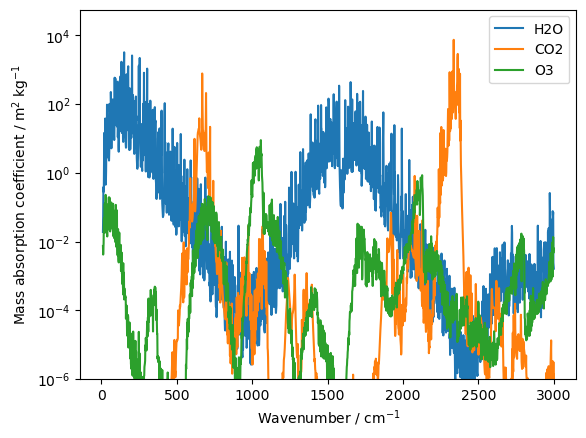

In [4]:
species="H2O"
h2o_spec = SingleSpeciesAbsorption_tmp(species=species,cutoff=750e9)


atm = pyarts.arts.AtmPoint()
atm.set_species_vmr(species[:3], 0.5)
atm.temperature = 260
atm.pressure = 0.5e5

h2o_abs = h2o_spec(f, atm)
plt.semilogy(wn,  h2o_abs, label = species)


species = "CO2"
co2_spec = SingleSpeciesAbsorption_tmp(species=species,cutoff=750e9)

atm = pyarts.arts.AtmPoint()
atm.set_species_vmr(species, 288e-3)
atm.temperature = 260
atm.pressure = 0.5e5

co2_abs = co2_spec(f, atm)
plt.semilogy(wn,co2_abs, label = species)


species = "O3"
o3_spec = SingleSpeciesAbsorption_tmp(species=species, cutoff=750e9)

atm = pyarts.arts.AtmPoint()
atm.set_species_vmr(species, 9e-3)
atm.temperature = 260
atm.pressure = 0.5e5

o3_abs = o3_spec(f, atm) 
plt.semilogy(wn,o3_abs, label = species)


plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Mass absorption coefficient / m$^2$ kg$^{-1}$")
plt.legend()
plt.ylim(1e-6)

In [5]:
# import os

# # # To save data
# # data_folder = 'data'
# # os.makedirs(data_folder, exist_ok=True)

# # # Assuming wn, h2o_abs, co2_abs, o3_abs are already defined
# # np.save(os.path.join(data_folder, 'wn.npy'), wn)
# # np.save(os.path.join(data_folder, 'h2o_abs.npy'), h2o_abs)
# # np.save(os.path.join(data_folder, 'co2_abs.npy'), co2_abs)
# # np.save(os.path.join(data_folder, 'o3_abs.npy'), o3_abs)

# # print(f"Arrays saved in the '{data_folder}' folder.")

# # # to read data; so that you can run without ARTS
# data_folder = 'data'

# # Load the saved arrays from the 'data' folder
# wn = np.load(os.path.join(data_folder, 'wn.npy'))
# h2o_abs = np.load(os.path.join(data_folder, 'h2o_abs.npy'))
# co2_abs = np.load(os.path.join(data_folder, 'co2_abs.npy'))
# o3_abs = np.load(os.path.join(data_folder, 'o3_abs.npy'))

(1e-06, np.float64(56183.97402661447))

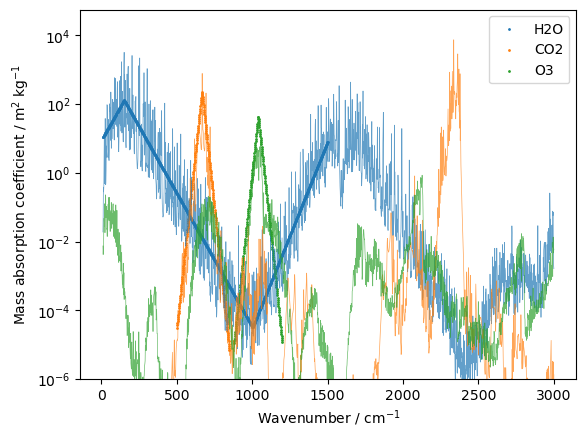

In [6]:
from spectral_calc import *

plt.scatter(wn, h2o_abs_coef_nu(wn), label = 'H2O', s = 1)
plt.scatter(wn, co2_abs_coef_nu(wn), label = 'CO2', s = 1)
plt.scatter(wn, o3_abs_coef_nu(wn), label = 'O3', s = 1)

plt.semilogy(wn,  h2o_abs, alpha =0.7, lw = 0.5)
plt.semilogy(wn,  co2_abs, alpha = 0.7, lw = 0.5)
plt.semilogy(wn,  o3_abs, alpha = 0.7, lw = 0.5)

plt.yscale('log')
plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Mass absorption coefficient / m$^2$ kg$^{-1}$")
plt.legend()
plt.ylim(1e-6)

Net Transmnissivity = 0.333


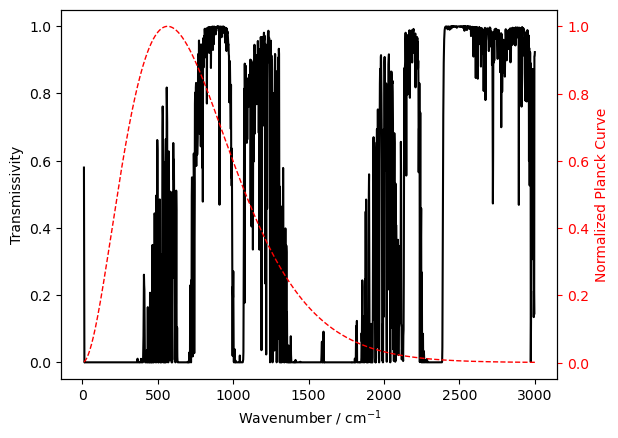

In [7]:
m_h2o = column_mass_h2o(288.) # typical surface temperature
m_co2 =  column_mass_co2(280.e-6) # pre-industrial levels of CO2 
m_o3  = column_mass_o3()

trans = np.exp(-(h2o_abs*m_h2o + co2_abs*m_co2 + o3_abs*m_o3))

plt.plot(wn, trans, color = "k")

plt.xlabel("Wavenumber / cm$^{-1}$")
plt.ylabel("Transmissivity")

ax2 = plt.twinx()
B = planck_nu(wn, T=288.)
ax2.plot(wn, B/max(B), label="Normalized Planck curve", color="r", ls = "dashed", lw = 1 ,zorder=1)
# ax2.legend(loc = "upper left", frameon=False)

# Set the label for the secondary y-axis
ax2.set_ylabel("Normalized Planck Curve", color="r")
    
# Set the tick colors for the secondary y-axis to red
ax2.tick_params(axis='y', colors='r')


atm_transmissivity = np.trapezoid(trans * B, wn) / np.trapezoid(B, wn)

print(f"Net Transmnissivity = {atm_transmissivity:0.3f}")

In [8]:
trans_2xco2 = np.exp(-(h2o_abs*m_h2o + co2_abs*2*m_co2 + o3_abs*m_o3))

atm_transmissivity_2xco2 = np.trapezoid(trans_2xco2 * B, wn) / np.trapezoid(B, wn)

print(f"Net Transmnissivity 2x CO2  = {atm_transmissivity_2xco2:0.3f}")

Net Transmnissivity 2x CO2  = 0.322


In [9]:
EMIS = 0.95
STBO = 5.67e-8 # W m-2 K-4

def outgoing_longwave_rad(TS,  TRANS, EMIS= EMIS, ):
    return 0.5* (1 + TRANS) * EMIS * STBO * TS**4 

TS = 288.

olr_ref = outgoing_longwave_rad(TS = TS, TRANS= atm_transmissivity)
olr_2x =  outgoing_longwave_rad(TS = TS, TRANS= atm_transmissivity_2xco2)

print(f"2x CO2 Forcing (Gray) = { olr_ref - olr_2x:.2f} W/ m2")

2x CO2 Forcing (Gray) = 1.89 W/ m2


In [10]:
B = planck_nu(wn, T=288.)
olr_ref = np.trapezoid(trans * B, wn*100) 
olr_2x = np.trapezoid(trans_2xco2 * B, wn*100) 

print(f"2x CO2 Forcing (Spectral) = { olr_ref - olr_2x:.2f} W/ m2")

2x CO2 Forcing (Spectral) = 3.98 W/ m2


In [11]:
T_surf = 288.0          


B = planck_nu(wn, T_surf)  # [W/m^2/sr/(cm^-1)]

olr_flux = np.trapezoid(B, wn*100)    # [W/m^2]
olr_flux,  outgoing_longwave_rad(T_surf, 1.,1.)


(np.float64(390.02569420042056), 390.0793946112)